Gera Difrações
=============
Gera um dado sintético de difrações

---

In [2]:
from __future__ import print_function
import numpy as np
from scipy.signal import convolve2d

# Importa bibliotecas próprias
from utils import * 

# Configura o matplolib para plotar inline
# %matplotlib qt5
# %matplotlib notebook

In [3]:
data_size = 1000
dt = 0.004
dx = 12.5

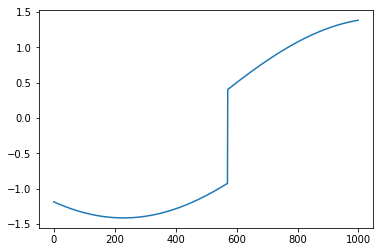

In [4]:
# Cria curva caótica
num_steps = data_size
num_sections = 2
theta_end = (2*np.pi)*0.4

sections = np.empty(num_sections+1, dtype=np.int)
sections[0] = 0
sections[-1] = num_steps
if num_sections > 1:
    sections[1:-1] = np.sort(np.random.choice(np.arange(int(num_steps*0.05),int(num_steps*0.95)),
                                              (num_sections-1),replace=False))

count = 0
phase = np.random.random()*(2*np.pi)
theta = np.empty(num_steps, dtype=np.float32)
for begin,end in zip(sections[:-1],sections[1:]):
    theta[begin:end] = 2**count
    count+=1

theta = np.arange(0,theta_end,theta_end/num_steps) + theta + phase
chaos = np.cos(theta) + np.sin(theta)
plt.plot(np.arange(num_steps), chaos)
#plt.ylim((0,num_steps))
plt.show()

In [5]:
# Random walk com equação caótica
num_steps = data_size
beta = 0.98
sigma = 1.0

random_walk = np.empty(num_steps, dtype=np.float32)
step = (np.random.random() - 0.5) * 8
for i in range(num_steps):
    random_walk[i] = step
    step = (1-beta)*np.random.normal(loc=chaos[i], scale=sigma) + beta*step
    
random_walk -= random_walk.min()
    

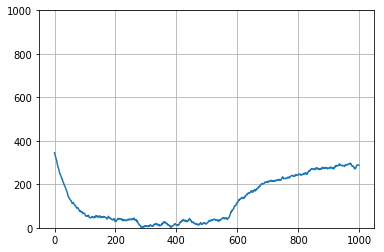

In [6]:
# Random walk com equação caótica
scale = 100
offset = 0

reflective_curve = np.round((random_walk*scale) + offset)
    
plt.plot(range(num_steps), reflective_curve)
plt.ylim((0,data_size))
plt.grid(True)
plt.show()

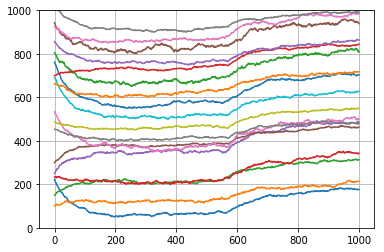

In [7]:
beta = 0.98

for offset in range(50,950,50):
    sigma = np.random.rand() + 1.0
    random_walk = np.empty(num_steps, dtype=np.float32)
    step = (np.random.random() - 0.5) * 8
    for i in range(num_steps):
        random_walk[i] = step
        step = (1-beta)*np.random.normal(loc=chaos[i], scale=sigma) + beta*step
    random_walk -= random_walk.min()
    
    scale = np.random.rand()*30 + 30
    reflective_curve = np.round((random_walk*scale) + offset)

    plt.plot(range(num_steps), reflective_curve)
    
plt.ylim((0,data_size))
plt.grid()
plt.show()

In [8]:
# Gera modelo de velocidades
data_size = 1000

# Determina velocidades nos cantos da imagem
up_left = 1500
up_right = 1500
down_left = 3000
down_right = 4000

# Determina velocidade de algumas camadas
layers = [2000, 2200, 2700]

# Instancia modelo com zeros
velocity_map = np.zeros((data_size,data_size), dtype=np.float32)


In [9]:
# Gera velocidade suavizada para testes
v_begin = 1500.0
v_end = 4000.0

mu = np.empty((data_size,data_size), dtype=np.float32)
mu[:,:] = np.arange(v_begin,v_end,(v_end-v_begin)/data_size).reshape((-1,1)) 
sigma = mu*0.07
velocity_map = np.random.normal(loc=mu, scale=sigma)


Tamanho da imagem (em polegadas): 13.89 x 13.89
Coordenadas:  x - [0.0, 1000.0], y - [0.0, 4.0]
Dimensão: (1000, 1000)



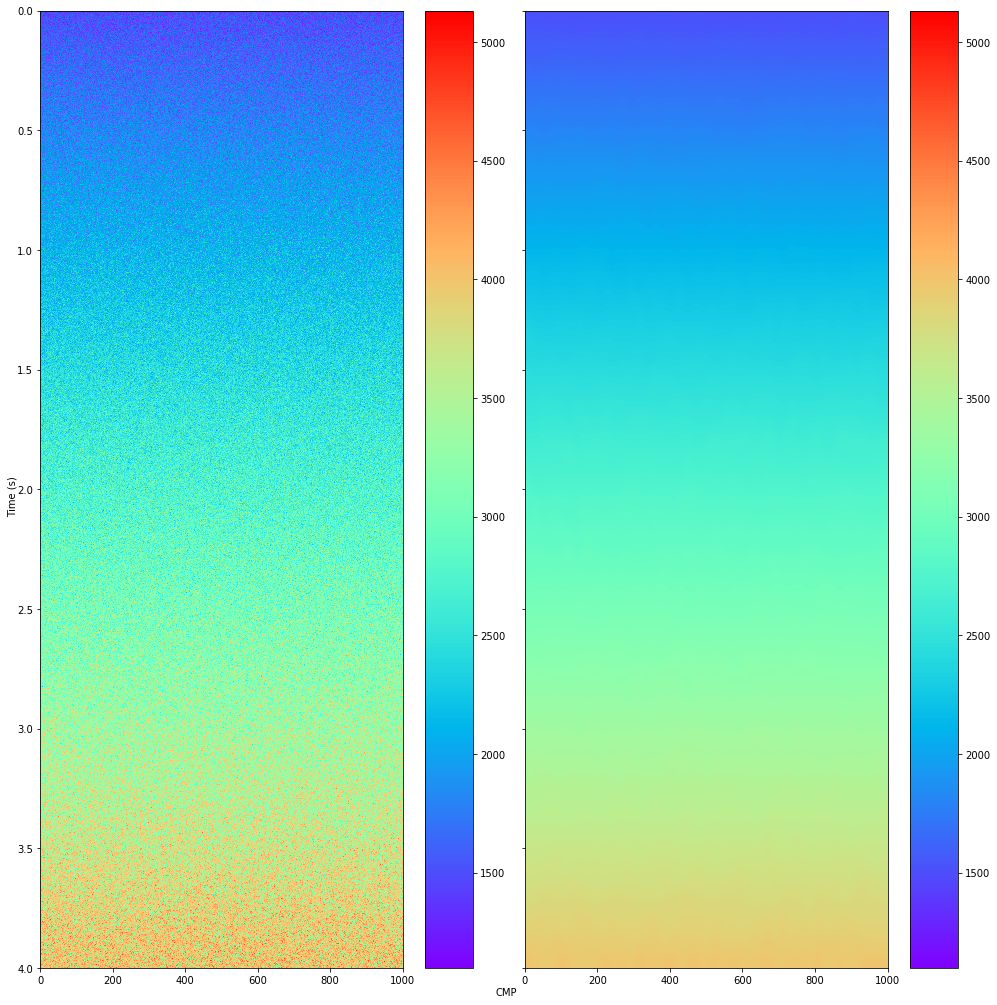

In [10]:
# Aplica filtro para remover transições bruscas da imagem
from scipy.ndimage import gaussian_filter

#sigma = [30.0, 10.0]
sigma = 10.0
title = "Filtro Gaussiano - sigma=" + str(sigma)

filtered_map = gaussian_filter(velocity_map, sigma=sigma)
vmin = min(velocity_map.min(), filtered_map.min())
vmax = max(velocity_map.max(), filtered_map.max())

multiple_event_viewer(velocity_map, filtered_map, dt=dt, 
                    vmin1=vmin, vmax1=vmax,
                    vmin2=vmin, vmax2=vmax,
                    color1='rainbow', color2='rainbow')

In [11]:
# Construir difrações
diff_leg_size = 80
num_apices = data_size/2

apices = np.random.randint(50, data_size-50, size=num_apices).reshape((-1,2))
#apices = np.array([[250, 250], [250, 750], [750,250], [750,750]])
mid_points = np.arange(data_size)*dx

diffrac_edges = np.zeros((data_size,data_size), dtype=np.float32)

for [t_ind, x_ind] in apices:
    t0 = t_ind*dt
    velocity = velocity_map[t_ind,x_ind]
    x_begin = max(0, x_ind-diff_leg_size)
    x_end = min(data_size, x_ind+diff_leg_size+1)
    horiz_indices = np.arange(x_begin,x_end).astype(int)
    offsets = mid_points[horiz_indices] - mid_points[x_ind]
    
    # Computa os tempos usando equação da curva
    times = np.sqrt(t0**2 + ((2*offsets)/velocity)**2)
    vert_indices = (np.floor(times/dt)).astype(int)
    # Considera somente os índices que não ultrapassaram o final do painel
    valid_indices = np.where(vert_indices < data_size)[0]
    curve = np.ones(valid_indices.size, dtype=np.float32)
    curve = apply_taper(curve, diff_leg_size)
    diffrac_edges[vert_indices[valid_indices],horiz_indices[valid_indices]] = curve
    

Wavelet_2D (71, 9)
Tamanho da imagem (em polegadas): 1.25 x 9.86


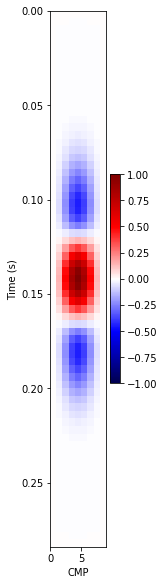

In [12]:
frequency = 10.0
taper_size = 4
window_size = 71

# Constrói wavelet
wavelet = ricker_wavelet(frequency, window_size, dt)
# Constrói wavelet 2D
wavelet = wavelet.reshape((1,-1)).T
wavelet_2D = np.empty((window_size, taper_size*2+1), dtype=np.float32)
wavelet_2D[:,:] = wavelet
# Suaviza bordas aplicando função de taper
wavelet_2D = apply_taper(wavelet_2D, taper_size)
print("Wavelet_2D", wavelet_2D.shape)

# Visualiza
color='seismic'
resize=10.0

view_seismic_stack(wavelet_2D, resize=resize, color=color, dt=dt, vmin=-wavelet_2D.max(), vmax=wavelet_2D.max())

In [13]:
# Convolve com difrações
diffractions = convolve2d(diffrac_edges, wavelet_2D, mode='same')

Tamanho da imagem (em polegadas): 13.89 x 13.89


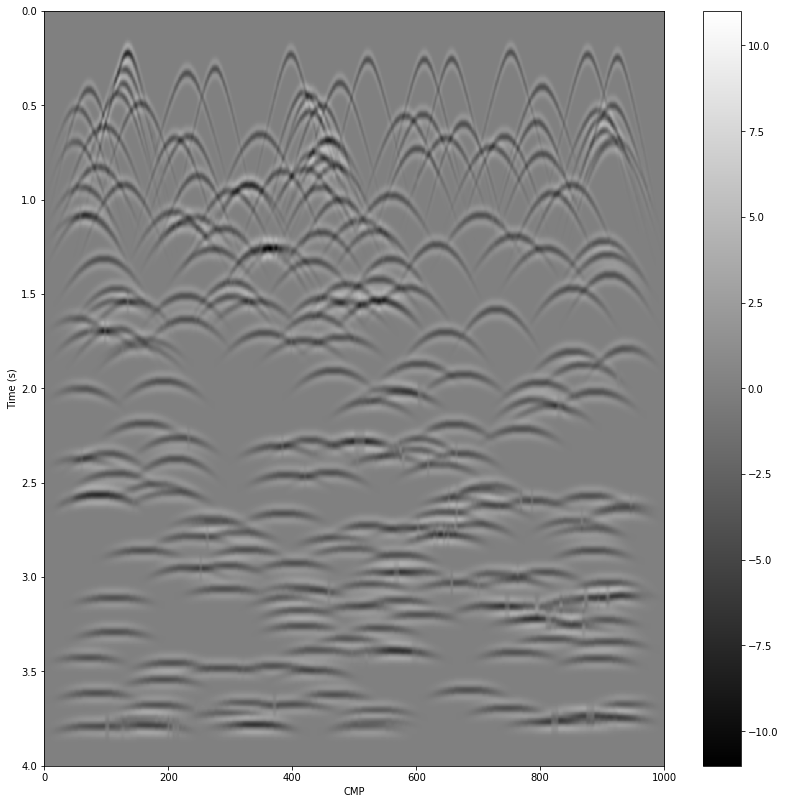

In [14]:
color='gray'
clip=1.0

vmax = diffractions.max()

view_seismic_stack(-1*diffractions, color=color, dt=dt, clip_percent=clip, vmin=-vmax, vmax=vmax)

---
Abaixo, células extras (apagar eventualmente)

Carregando o empilhamento ./reflexoes_migradas/solimoes_migrado.sgy
2206 traços:
 - CDP: [17 - 2223]
 - Amostras por traço (ns): 751
 - Tempo entre amostras (dt): 4.0 ms
Dimensões do dado 1: (751, 2206)

Tamanho da imagem (em polegadas): 30.64 x 10.43
Coordenadas:  x - [17.0, 2223.0], y - [0.0, 3.0]
Dimensão: (751, 2206)



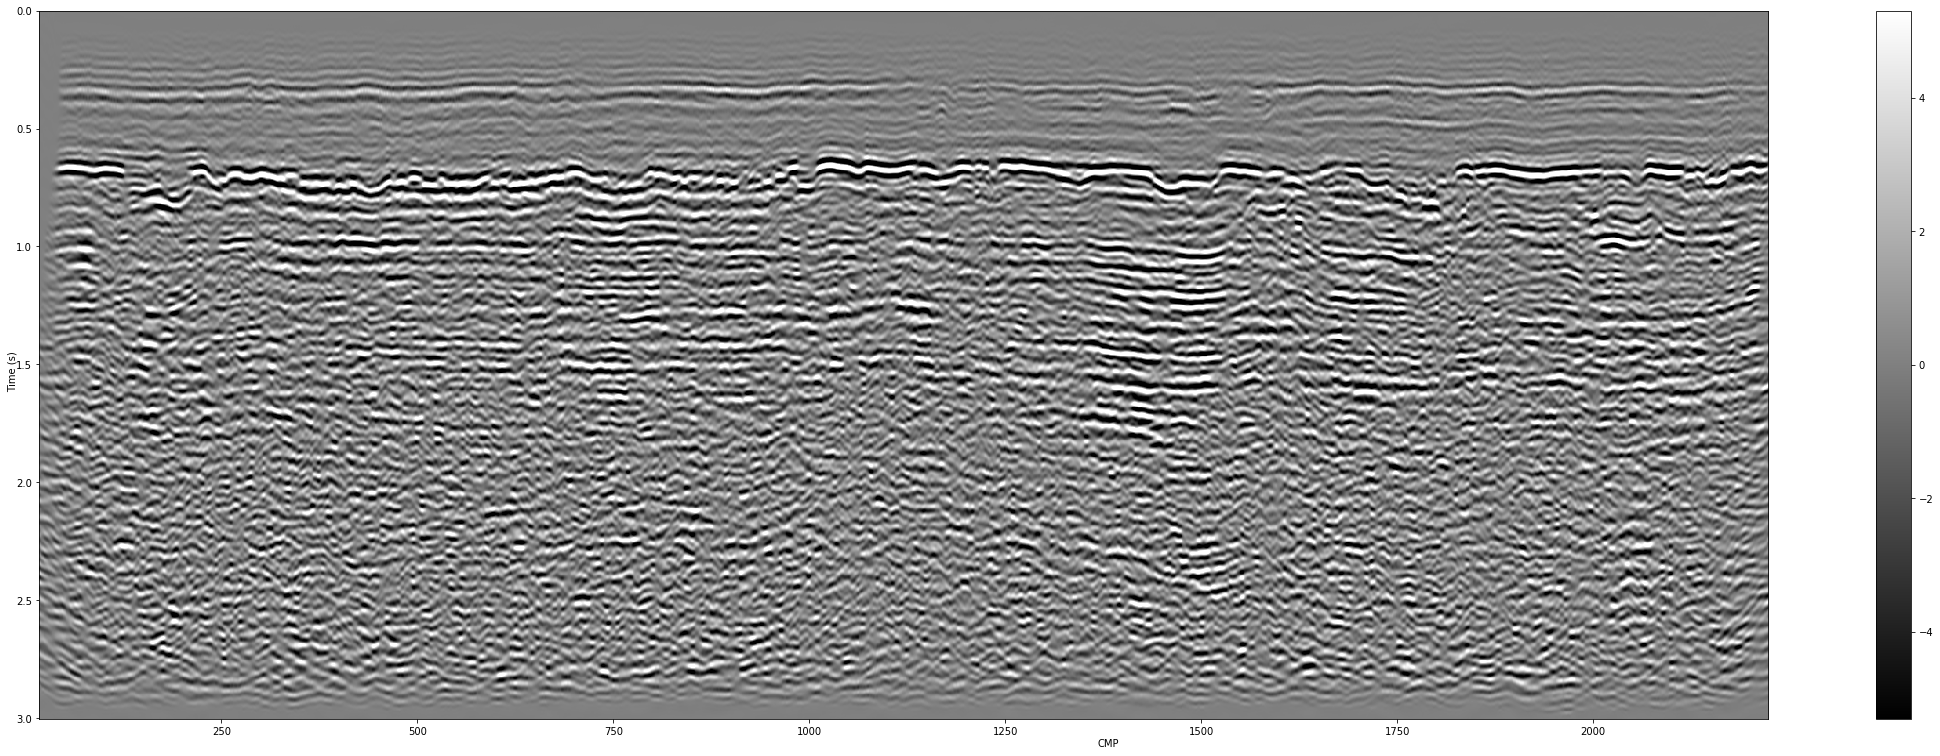

In [15]:
# Importa dado

# Definição de arquivos de entrada
stack_file = './reflexoes_migradas/solimoes_migrado.sgy'

# Definição plot
color = 'gray'
clip = 0.3

# Carrega dados
if not stack_file is None: 
    traces = load_traces(stack_file)
    stack_image = get_data_from_traces(traces)
    print("Dimensões do dado 1:", stack_image.shape)
    print()
    
multiple_event_viewer(stack_image, cdp_offset=traces[0].cdp, dt=traces[0].dt,
             clip_percent1=clip, color1=color)

In [16]:
# Extrator de arestas

# Definição filtro
threshold = 0.12

# Definição plot
color = 'gray'
clip = 0.3

# Normaliza
vmax = np.abs((stack_image.min(), stack_image.max())).max()
stack_image /= vmax
    
# Torna dado binario
binary_image = stack_image.copy()
indices = np.where(binary_image < 0.0)
binary_image[indices] = 0.0
binary_image /= binary_image.max()
binary_image[binary_image < threshold] = 0.0
binary_image[binary_image >= threshold] = 1.0

# Aplica detector de arestas
binary_edges = skeletonize(binary_image)
gray_edges = binary_edges * stack_image

multiple_event_viewer(stack_image, gray_edges,
             vmin2=gray_edges.min(), vmax2=gray_edges.max(),
             cdp_offset=traces[0].cdp, dt=traces[0].dt,
             clip_percent1=clip, color1=color, color2=color)

NameError: name 'skeletonize' is not defined

In [ ]:
def agc(stack_image, window_size, dt):
    window_size = int(np.floor(window_size/dt))
    agc_image = stack_image.copy()
    abs_image = np.abs(stack_image)
    vmax = abs_image.max()
    end = stack_image.shape[0]-window_size
    for i in range(end):
        means = np.mean(abs_image[i:i+window_size,:], axis=0)
        correct_factor = vmax / means
        agc_image[i,:] = stack_image[i,:] * correct_factor
    # Trata o final do dado
    #for i in range(stack_image.shape[0],end-1,-1):
    #    means = np.mean(abs_image[i-window_size:i,:], axis=0)
    #    agc_image[i-1,:] = stack_image[i-1,:] / means
    for i in range(end,stack_image.shape[0]):
        agc_image[i,:] = stack_image[i,:] / means
    
    return agc_image

In [ ]:
agc_image = agc(stack_image, 0.1, traces[0].dt)

# Normaliza
vmax = np.abs(agc_image).max()
agc_image /= vmax

In [ ]:
# Definição plot
color = 'seismic'
clip = 1.0

    
multiple_event_viewer(agc_image, cdp_offset=traces[0].cdp, dt=traces[0].dt,
             clip_percent1=clip, color1=color)

In [ ]:
# Extrator de arestas

# Definição filtro
threshold = 0.02

# Definição plot
color = 'seismic'
clip = 0.5

# Normaliza
vmax = np.abs((stack_image.min(), stack_image.max())).max()
stack_image /= vmax
    
# Torna dado binario
binary_image = agc_image.copy()
indices = np.where(binary_image < 0.0)
binary_image[indices] = 0.0
binary_image /= binary_image.max()
binary_image[binary_image < threshold] = 0.0
binary_image[binary_image >= threshold] = 1.0

# Aplica detector de arestas
binary_edges = skeletonize(binary_image)
gray_edges = binary_edges * stack_image

multiple_event_viewer(stack_image, gray_edges,
             vmin2=gray_edges.min(), vmax2=gray_edges.max(),
             cdp_offset=traces[0].cdp, dt=traces[0].dt,
             clip_percent1=clip, color1=color, color2='gray')

In [ ]:
# Definição plot
color = 'seismic'
clip = 1.0

vmax = np.abs(stack_image).max()
stack_image /= vmax
    
multiple_event_viewer(agc_image, stack_image, cdp_offset=traces[0].cdp, dt=traces[0].dt,
             clip_percent1=clip, color1=color, clip_percent2=clip, color2=color)

In [ ]:
# Salva dados
save_file = 'estruturas/solimoes_edges.pickle'

pickle_data(save_file, [gray_edges], ['edges'])